### Explore grassmann distance as a metric for distance between subspaces

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData

import scipy



In [3]:
# all the possible feature dimensions 
# NOTE: Capital 1st letter is the convention here
FEATURE_DIMS = ["Color", "Shape", "Pattern"]

# the output directory to store the data
OUTPUT_DIR = "/data/patrick_res/pseudo"

HYAK_OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"

EVENT = "FeedbackOnset"  # event in behavior to align on
PRE_INTERVAL = 1300   # time in ms before event
POST_INTERVAL = 1500  # time in ms after event
INTERVAL_SIZE = 100  # size of interval in ms

In [4]:
def calculate_grassmann_distance(A, B):
    """
    A: N x M matrix as an np array
    B: N x M matrix as an np array 
    Where N >= M, each matrix represents an M dim subspace in N dims
    """
    orth_A = scipy.linalg.orth(A)
    orth_B = scipy.linalg.orth(B)
    prod = orth_A.T @ orth_B
    _, s, _ = scipy.linalg.svd(prod)
    # svd sometimes gives back values larger than 1 due to precision errors
    s[s > 1] = 1
    thetas = np.arccos(s)
    return np.sqrt(np.sum(thetas ** 2))

def get_distances_between_splits(a_splits, b_splits):
    split_distances = []
    for a_model in a_splits:
        for b_model in b_splits:
            a_coefs = a_model.coef_.T
            b_coefs = b_model.coef_.T
            distance = calculate_grassmann_distance(a_coefs, b_coefs)
            split_distances.append(distance)
    return np.array(split_distances)

def get_distances_between_models(a_models, b_models):
    distances = []                
    for time_idx in range(a_models.shape[0]):
        split_distances = get_distances_between_splits(a_models[time_idx, :], b_models[time_idx, :])
        distances.append(split_distances)
    return np.array(distances)

def get_max_grassman_distance(n):
    return np.sqrt((np.pi / 2) ** 2 * n)

def get_cross_distance_for_models(models):
    cross_distances = np.empty((models.shape[0], models.shape[0]))
    for time_i in range(models.shape[0]):
        for time_j in range(models.shape[0]):
            split_distances = get_distances_between_splits(models[time_i, :], models[time_j, :])
            cross_distances[time_i, time_j] = np.mean(split_distances)
    return cross_distances


In [5]:
A = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]]).reshape(2, 6).T
B = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]]).reshape(2, 6).T
calculate_grassmann_distance(A, B)

0.0

In [6]:
np.sqrt((np.pi / 2) ** 2 * 4)

3.141592653589793

### Try this out on correct vs incorrect feedback decoding

/tmp/ipykernel_909463/2253410945.py:11: RuntimeWarning: invalid value encountered in arccos
  thetas = np.arccos(s)


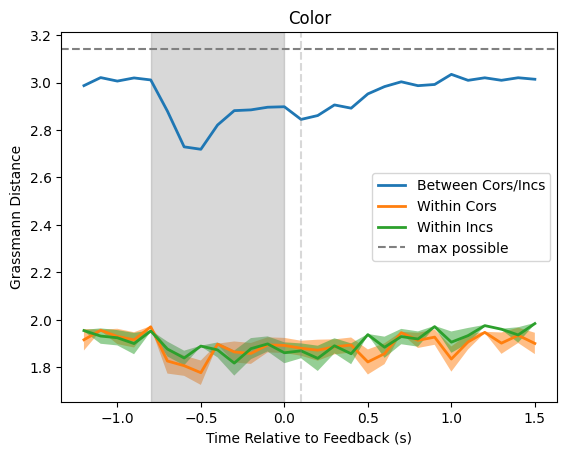

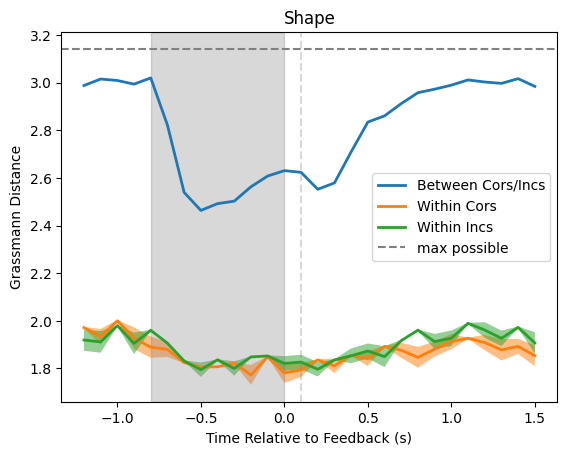

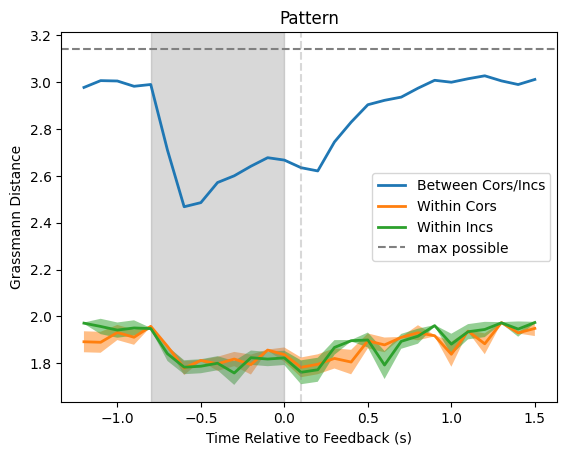

In [8]:
for feature_dim in FEATURE_DIMS:
    cor_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_all_cor_models.npy"), allow_pickle=True)
    inc_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_all_inc_models.npy"), allow_pickle=True)
    cross_distances = get_distances_between_models(cor_models, inc_models)
    between_cor_distances = get_distances_between_models(cor_models, cor_models)
    between_inc_distances = get_distances_between_models(inc_models, inc_models)

    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        cross_distances,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Between Cors/Incs",
        right_align=True, 
        sem=True
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        between_cor_distances,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Within Cors",
        right_align=True, 
        sem=True
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        between_inc_distances,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Within Incs",
        right_align=True, 
        sem=True
    )
    # add grey band for selection period
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    # add dotted line for feedback start
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    max = get_max_grassman_distance(4)
    ax.axhline(max, color='gray', linestyle='dashed', label="max possible")
    # add estimated chance
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Grassmann Distance")
    ax.set_title(f"{feature_dim}")
    ax.legend()

### Now do it for the combined 12D subspace

In [27]:
cor_models.shape

(28, 8)

### Evaluate cross distance from original feature dim decoders

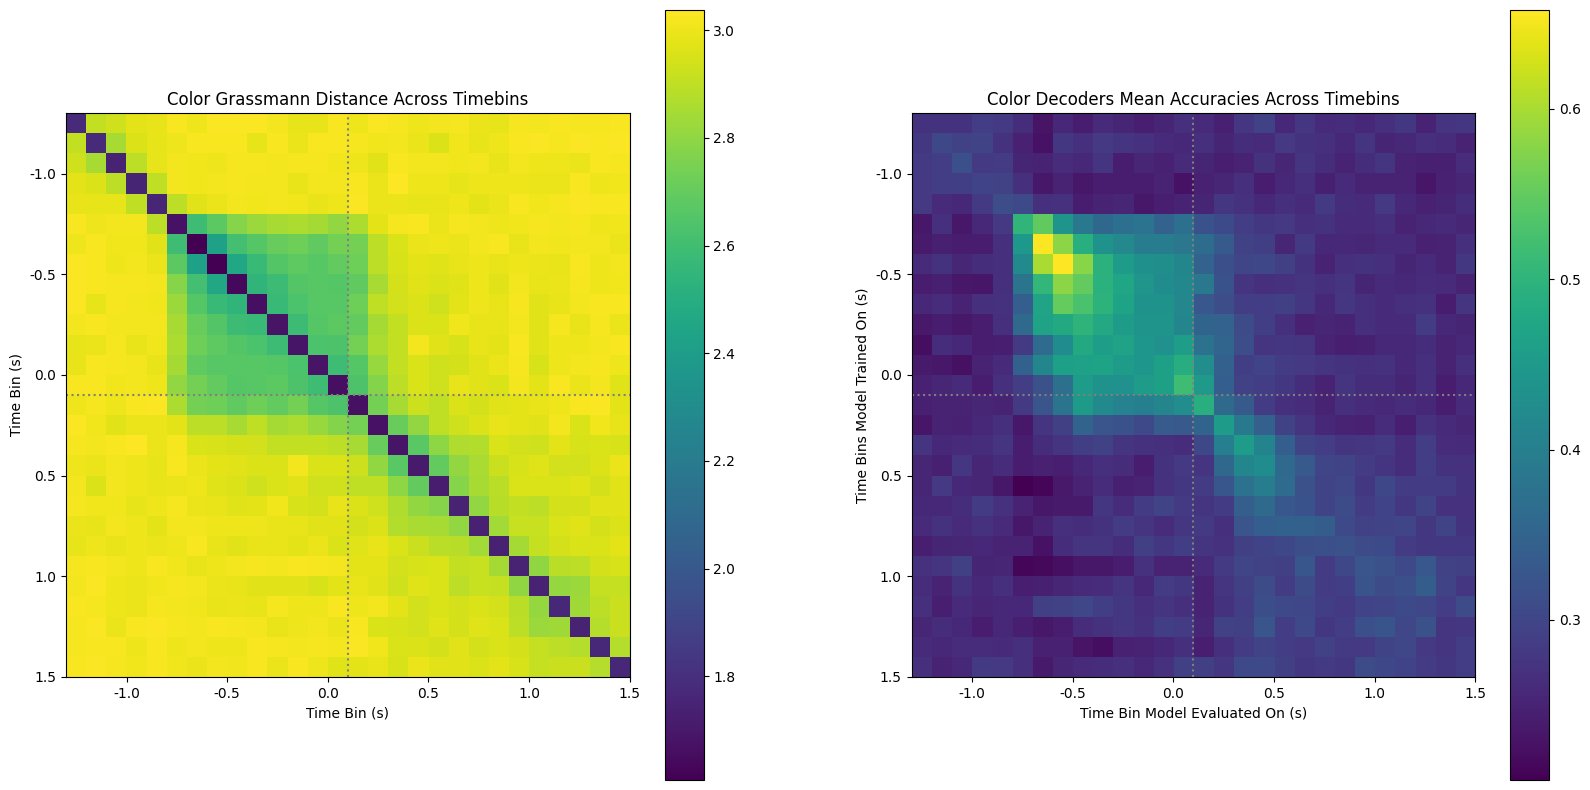

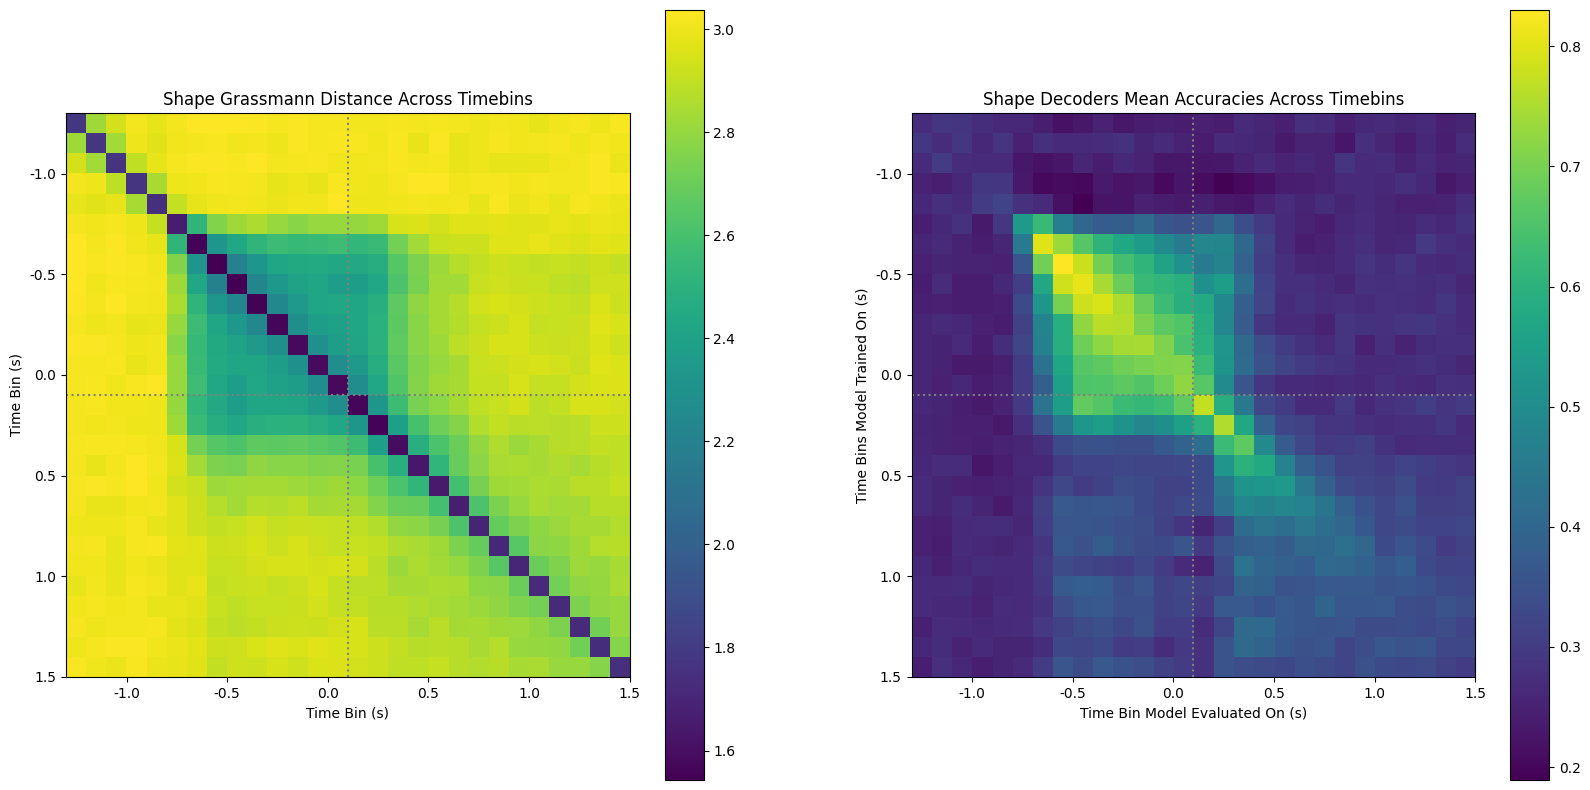

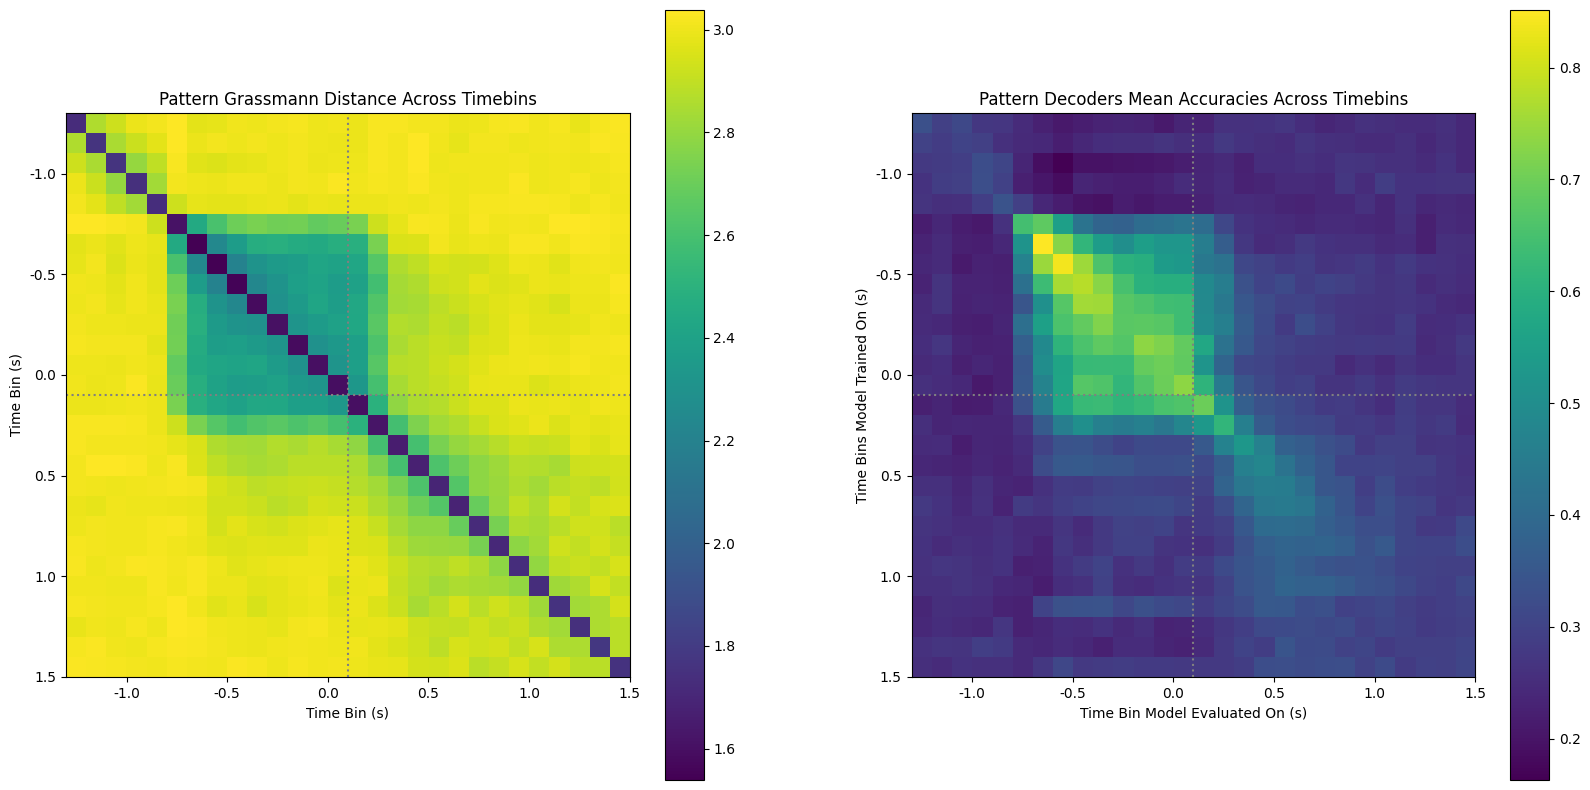

In [7]:
def show_cross(data, ax, fig):
    colors = ax.matshow(data)
    fig.colorbar(colors, ax=ax)

    ratio = 1000 / 100
    tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
    tick_pos = (tick_labels + 1.3) * ratio - 0.5
    # tick_labels = np.arange(len(cross_accs))
    # tick_pos = np.arange(len(cross_accs))
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels)
    ax.xaxis.tick_bottom()
    ax.set_yticks(tick_pos)
    ax.set_yticklabels(tick_labels)
    ax.axvline(13.48, color="gray", linestyle="dotted", linewidth=1.5)
    ax.axhline(13.48, color="gray", linestyle="dotted", linewidth=1.5)


for feature_dim in FEATURE_DIMS:
    models = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_rpe_sess_models.npy"), allow_pickle=True)    
    cross_distances = get_cross_distance_for_models(models)
    cross_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_rpe_sess_cross_accs.npy"))
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    show_cross(cross_distances, ax[0], fig)
    ax[0].set_xlabel("Time Bin (s)")
    ax[0].set_ylabel("Time Bin (s)")
    ax[0].set_title(f"{feature_dim} Grassmann Distance Across Timebins")

    show_cross(cross_accs, ax[1], fig)
    ax[1].set_xlabel("Time Bin Model Evaluated On (s)")
    ax[1].set_ylabel("Time Bins Model Trained On (s)")
    ax[1].set_title(f"{feature_dim} Decoders Mean Accuracies Across Timebins")